### Importing Libs

In [4]:
import os
import shutil

import pandas as pd
import tensorflow as tf
from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

2023-05-19 09:18:50.949704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 09:18:51.046773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-19 09:18:51.047641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 09:18:52.234645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
%matplotlib inline

In [7]:
LOGDIR = "./text_models"
DATA_DIR = "../datasets"

### Load data

In [8]:
DATASET_NAME = "titles_full.csv"
TITLE_SAMPLE_PATH = os.path.join(DATA_DIR, DATASET_NAME)
COLUMNS = ["title", "source"]

titles_df = pd.read_csv(TITLE_SAMPLE_PATH, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,holy cash cow batman - content is back,nytimes
1,show hn a simple and configurable deployment ...,github
2,show hn neural turing machine in pure numpy. ...,github
3,close look at a flu outbreak upends some commo...,nytimes
4,lambdalite a functional relational lisp data...,github


In [9]:
CLASSES = {"github": 0, "nytimes": 1, "techcrunch": 2}
N_CLASSES = len(CLASSES)

In [10]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes)
    return one_hots

In [11]:
encode_labels(titles_df.source[:4])

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

### Data Prep

In [13]:
DATASET_SIZE = titles_df.shape[0]
N_TRAIN = int(DATASET_SIZE * 0.80)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN],
    titles_df.source[:N_TRAIN],
)

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:],
    titles_df.source[N_TRAIN:],
)

In [14]:
sources_train.value_counts()

github        29175
techcrunch    24784
nytimes       23003
Name: source, dtype: int64

In [15]:
sources_valid.value_counts()

github        7350
techcrunch    6107
nytimes       5784
Name: source, dtype: int64

In [16]:
Y_train = encode_labels(sources_train)
Y_valid = encode_labels(sources_valid)

### Preprocessing

In [18]:
MAX_LEN = 26
MAX_TOKENS = 20000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, max_tokens=MAX_TOKENS
)

In [19]:
preprocessing_layer.adapt(titles_df.title)

In [20]:
X_train, X_valid = titles_train, titles_valid
X_train[:5]

0              holy cash cow  batman - content is back
1    show hn  a simple and configurable deployment ...
2    show hn  neural turing machine in pure numpy. ...
3    close look at a flu outbreak upends some commo...
4    lambdalite  a functional  relational lisp data...
Name: title, dtype: object

In [21]:
integers = preprocessing_layer(X_train[:5])
integers

<tf.Tensor: shape=(5, 26), dtype=int64, numpy=
array([[ 6236,   538,  9221,     1,   295,    14,   162,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   12,    13,     4,    47,     8,  3862,  1252,    79,     5,
           30,   454,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [   12,    13,  1484,  2853,   315,     6,   584,  8144,  5553,
           75,   242,  1942,    18,  1169,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [ 1034,   304,    23,     4,  3713,  7509, 14383,   199,   678,
         4512,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,     4,   604,  4221,   553,   280,     6,  2052,   491,
            7,   678,   553,     0,     0,     0,     

In [22]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

20000

### Building DNN model

In [24]:
def build_dnn_model(embed_dim):
    model = Sequential(
        [
            Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]
            ),
            Lambda(lambda x: tf.reduce_mean(x, axis=1)),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

Epoch 1/100
257/257 [==============================] - 2s 6ms/step - loss: 1.0636 - accuracy: 0.3956 - val_loss: 1.0067 - val_accuracy: 0.5196
Epoch 2/100
257/257 [==============================] - 1s 5ms/step - loss: 0.9195 - accuracy: 0.6569 - val_loss: 0.8348 - val_accuracy: 0.7052
Epoch 3/100
257/257 [==============================] - 1s 6ms/step - loss: 0.7635 - accuracy: 0.7631 - val_loss: 0.7083 - val_accuracy: 0.7685
Epoch 4/100
257/257 [==============================] - 1s 5ms/step - loss: 0.6547 - accuracy: 0.7944 - val_loss: 0.6202 - val_accuracy: 0.7930
Epoch 5/100
257/257 [==============================] - 1s 5ms/step - loss: 0.5750 - accuracy: 0.8128 - val_loss: 0.5560 - val_accuracy: 0.8104
Epoch 6/100
257/257 [==============================] - 1s 6ms/step - loss: 0.5156 - accuracy: 0.8264 - val_loss: 0.5095 - val_accuracy: 0.8184
Epoch 7/100
257/257 [==============================] - 1s 5ms/step - loss: 0.4708 - accuracy: 0.8381 - val_loss: 0.4754 - val_accuracy: 0.8277

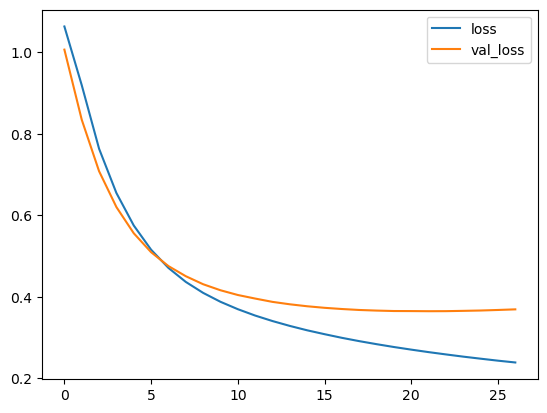

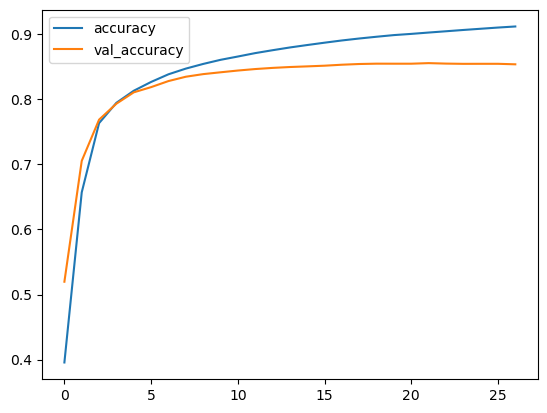

In [25]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "dnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300
EPOCHS = 100
EMBED_DIM = 10
PATIENCE = 5

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(dnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(dnn_history.history)[["accuracy", "val_accuracy"]].plot()

dnn_model.summary()

In [26]:
def get_predictions(model, instances):
    prediction = model.predict(instances)
    title_prediction = list(zip(instances, prediction))
    for line, predict in title_prediction:
        print(
            "Title: {} \nGithub:{:.2%} \nNYTimes:{:.2%} \nTechCrunch:{:.2%}".format(
                line, float(predict[0]), float(predict[1]), float(predict[2])
            )
        )


In [27]:
get_predictions(dnn_model, X_train[:5])

1/1 [==============================] - 0s 100ms/step
Title: holy cash cow  batman - content is back 
Github:1.13% 
NYTimes:83.05% 
TechCrunch:15.82%
Title: show hn  a simple and configurable deployment tool for github projects 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: show hn  neural turing machine in pure numpy. implements all 5 tasks from paper 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: close look at a flu outbreak upends some common wisdom 
Github:0.16% 
NYTimes:99.62% 
TechCrunch:0.21%
Title: lambdalite  a functional  relational lisp database in 250 lines of common lisp 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%


### Building RNN model

In [29]:
def build_rnn_model(embed_dim, units):
    model = Sequential(
        [
            Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ), 
            GRU(units), 
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Epoch 1/100
257/257 [==============================] - 12s 32ms/step - loss: 1.0923 - accuracy: 0.3750 - val_loss: 1.0830 - val_accuracy: 0.3820
Epoch 2/100
257/257 [==============================] - 6s 24ms/step - loss: 1.0488 - accuracy: 0.4527 - val_loss: 0.9763 - val_accuracy: 0.5691
Epoch 3/100
257/257 [==============================] - 6s 22ms/step - loss: 0.8099 - accuracy: 0.6193 - val_loss: 0.7000 - val_accuracy: 0.6378
Epoch 4/100
257/257 [==============================] - 6s 21ms/step - loss: 0.6498 - accuracy: 0.6514 - val_loss: 0.6320 - val_accuracy: 0.6578
Epoch 5/100
257/257 [==============================] - 5s 21ms/step - loss: 0.5973 - accuracy: 0.6857 - val_loss: 0.5981 - val_accuracy: 0.7086
Epoch 6/100
257/257 [==============================] - 6s 22ms/step - loss: 0.5640 - accuracy: 0.7286 - val_loss: 0.5736 - val_accuracy: 0.7329
Epoch 7/100
257/257 [==============================] - 5s 21ms/step - loss: 0.5366 - accuracy: 0.7552 - val_loss: 0.5522 - val_accuracy

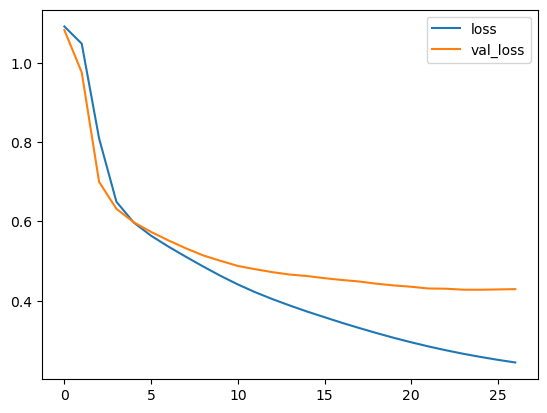

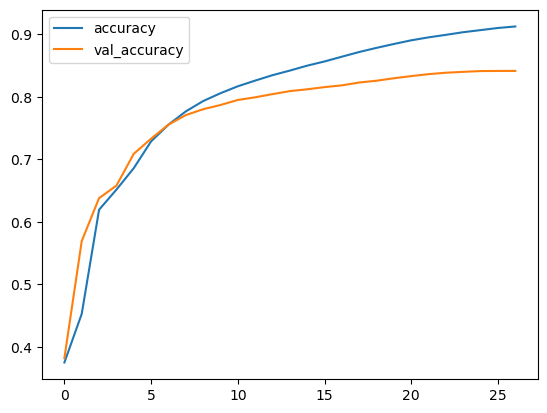

In [30]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "rnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 10
UNITS = 16
PATIENCE = 2

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

rnn_model.summary()

In [31]:
get_predictions(rnn_model, X_train[:5])

1/1 [==============================] - 1s 1s/step
Title: holy cash cow  batman - content is back 
Github:6.88% 
NYTimes:81.86% 
TechCrunch:11.26%
Title: show hn  a simple and configurable deployment tool for github projects 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: show hn  neural turing machine in pure numpy. implements all 5 tasks from paper 
Github:99.97% 
NYTimes:0.01% 
TechCrunch:0.03%
Title: close look at a flu outbreak upends some common wisdom 
Github:0.28% 
NYTimes:98.77% 
TechCrunch:0.94%
Title: lambdalite  a functional  relational lisp database in 250 lines of common lisp 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%


### Building CNN model

In [33]:
def build_cnn_model(embed_dim, filters, ksize, strides):
    model = Sequential(
        [
            Input(shape=(1,), dtype=tf.string),
            preprocessing_layer,
            Embedding(
                VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True
            ),
            Conv1D(
                filters=filters,
                kernel_size=ksize,
                strides=strides,
                activation="relu",
            ),
            Flatten(),
            Dense(N_CLASSES, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

Epoch 1/100
257/257 [==============================] - 3s 9ms/step - loss: 1.0804 - accuracy: 0.4062 - val_loss: 1.0407 - val_accuracy: 0.4921
Epoch 2/100
257/257 [==============================] - 2s 9ms/step - loss: 0.9475 - accuracy: 0.5625 - val_loss: 0.8322 - val_accuracy: 0.6217
Epoch 3/100
257/257 [==============================] - 2s 10ms/step - loss: 0.7329 - accuracy: 0.6629 - val_loss: 0.6637 - val_accuracy: 0.6801
Epoch 4/100
257/257 [==============================] - 2s 9ms/step - loss: 0.6159 - accuracy: 0.7032 - val_loss: 0.5990 - val_accuracy: 0.7049
Epoch 5/100
257/257 [==============================] - 2s 9ms/step - loss: 0.5626 - accuracy: 0.7290 - val_loss: 0.5626 - val_accuracy: 0.7360
Epoch 6/100
257/257 [==============================] - 2s 9ms/step - loss: 0.5255 - accuracy: 0.7575 - val_loss: 0.5345 - val_accuracy: 0.7570
Epoch 7/100
257/257 [==============================] - 2s 8ms/step - loss: 0.4930 - accuracy: 0.7807 - val_loss: 0.5095 - val_accuracy: 0.774

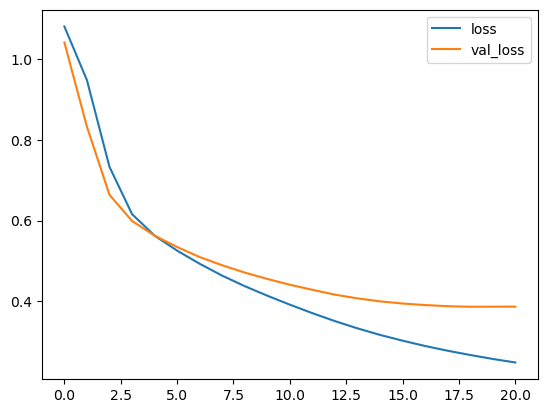

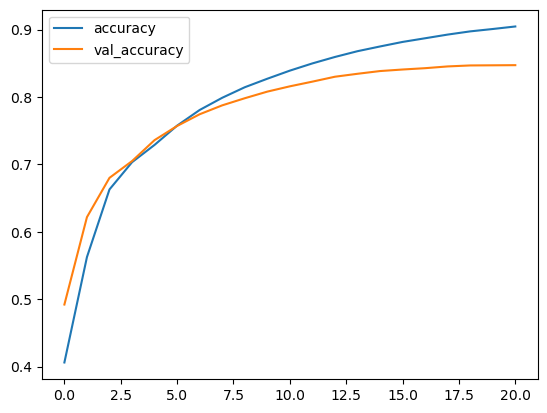

In [34]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, "cnn")
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 100
BATCH_SIZE = 300
EMBED_DIM = 5
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 2


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, Y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[["loss", "val_loss"]].plot()
pd.DataFrame(cnn_history.history)[["accuracy", "val_accuracy"]].plot()

cnn_model.summary()

In [35]:
get_predictions(cnn_model, X_train[:5])

1/1 [==============================] - 0s 84ms/step
Title: holy cash cow  batman - content is back 
Github:2.91% 
NYTimes:73.75% 
TechCrunch:23.35%
Title: show hn  a simple and configurable deployment tool for github projects 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: show hn  neural turing machine in pure numpy. implements all 5 tasks from paper 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
Title: close look at a flu outbreak upends some common wisdom 
Github:0.05% 
NYTimes:98.58% 
TechCrunch:1.36%
Title: lambdalite  a functional  relational lisp database in 250 lines of common lisp 
Github:100.00% 
NYTimes:0.00% 
TechCrunch:0.00%
